In [19]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from pathlib import Path

In [20]:
# Define the raw data folder
path = Path(r"C:\Users\ladom\Desktop\Player_churn_prediction\raw_data")

# Load CSVs into DataFrames
players = pd.read_csv(path / "players.csv")
bonuses = pd.read_csv(path / "bonuses.csv")
deposits = pd.read_csv(path / "deposits.csv")
bets = pd.read_csv(path / "bets.csv")
player_features = pd.read_csv(path / "player_features.csv")
player_features_drift = pd.read_csv(path / "player_features_test_drift.csv")
sessions = pd.read_csv(path / "sessions.csv")
withdraws = pd.read_csv(path / "withdrawals.csv")
print(players.head())
print(bonuses.head())
print(bets.head())
print(deposits.head())
print(player_features.head())
print(player_features_drift.head())
print(sessions.head())
print(withdraws.head())

   player_id username registration_date country  vip_level  acquisition  \
0          1   user_1        2025-08-29      SE          0  ad_campaign   
1          2   user_2        2025-07-30      IT          1    affiliate   
2          3   user_3        2025-08-04      FR          0        email   
3          4   user_4        2024-12-15      NO          0    affiliate   
4          5   user_5        2024-12-17      FR          0      organic   

   friends_count  messages_sent archetype  
0             13             10   regular  
1              8            108   regular  
2              1             20    casual  
3              8              4    casual  
4              2             10    casual  
                               bonus_id  player_id     bonus_type  \
0  8b054846-c29c-4252-a63b-e5b74352b9db        6.0  match_deposit   
1  7090ad56-a8e6-4b14-9c83-bbd8b922c6cd        7.0      free_spin   
2  d487effd-5a8b-42ca-81d4-29770c5df978        8.0  match_deposit   
3  725c4d

# Data Integration Strategy

Even though the CSV files don't enforce relations, we can merge these tables using `player_id` as the key. We'll:
1. Aggregate session-level data to player-level metrics
2. Aggregate withdrawal patterns
3. Calculate bonus usage statistics
4. Merge everything with our pre-computed features
5. Add player profile information

This gives us a complete view of player behavior for modeling.

In [28]:
# First, let's check for merge conflict markers or invalid values
def check_invalid_ids(df, col='player_id'):
    print(f"\nChecking {df.name if hasattr(df, 'name') else 'DataFrame'} for invalid IDs:")
    invalid_markers = ['>>>', '<<<', '===']
    mask = df[col].astype(str).str.contains('|'.join(invalid_markers), na=False)
    if mask.any():
        print("Found merge conflict markers in rows:")
        print(df[mask])
        # Clean by dropping these rows
        return df[~mask]
    return df

# Give names to our dataframes for better reporting
players.name = 'players'
player_features.name = 'player_features'
sessions.name = 'sessions'
withdraws.name = 'withdraws'
bonuses.name = 'bonuses'
bets.name = 'bets'

def ensure_int_player_id(df_list):
    """Drop NaN player_id and convert to int for each dataframe in df_list."""
    for df in df_list:
        if 'player_id' not in df.columns:
            print(f"Warning: dataframe {getattr(df, 'name', 'unknown')} has no 'player_id' column")
            continue
        # Drop rows with NaN player_ids
        original_len = len(df)
        df.dropna(subset=['player_id'], inplace=True)
        dropped = original_len - len(df)
        if dropped > 0:
            print(f"Dropped {dropped} rows with NaN player_id from {getattr(df, 'name', 'DataFrame')}")
        # Convert to int
        try:
            df['player_id'] = df['player_id'].astype(int)
        except Exception as e:
            print(f"Error converting player_id to int in {getattr(df, 'name', 'DataFrame')}: {e}")

ensure_int_player_id([players, player_features, sessions, withdraws, bonuses, bets])

# Convert timestamp columns to datetime (guard with existence checks)
_datetime_columns = [
    (sessions, 'login_time'),
    (sessions, 'logout_time'),
    (bonuses, 'issued_date'),
    (bonuses, 'redeemed_date'),
    (bets, 'bet_time'),
    (deposits, 'deposit_time'),
    (withdraws, 'withdrawal_time'),
    (players, 'registration_date')
]
for df, col in _datetime_columns:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# 1. Aggregate session-level metrics per player
if {'player_id', 'session_id', 'login_time', 'platform', 'device_type'}.issubset(sessions.columns):
    sessions_agg = sessions.groupby('player_id').agg(
        total_sessions=('session_id', 'count'),
        avg_session_length=('login_time', lambda x: (x.max() - x.min()).total_seconds() / 60 if x.notna().any() else 0),
        unique_platforms=('platform', 'nunique'),
        mobile_ratio=('device_type', lambda x: (x.str.lower().isin(['mobile', 'tablet'])).mean())
    ).reset_index()
else:
    print("sessions dataframe missing required columns for aggregation; creating empty sessions_agg")
    sessions_agg = pd.DataFrame(columns=['player_id', 'total_sessions', 'avg_session_length', 'unique_platforms', 'mobile_ratio'])

# 2. Aggregate withdrawal patterns
if {'player_id', 'withdrawal_id', 'amount'}.issubset(withdraws.columns):
    withdrawals_agg = withdraws.groupby('player_id').agg(
        total_withdrawal_amount=('amount', 'sum'),
        withdrawal_count=('withdrawal_id', 'count'),
        avg_withdrawal=('amount', 'mean')
    ).reset_index()
else:
    print("withdraws dataframe missing required columns for aggregation; creating empty withdrawals_agg")
    withdrawals_agg = pd.DataFrame(columns=['player_id', 'total_withdrawal_amount', 'withdrawal_count', 'avg_withdrawal'])

# 3. Calculate bonus usage statistics
if {'player_id', 'bonus_id', 'bonus_amount', 'redeemed_date'}.issubset(bonuses.columns):
    bonuses_agg = bonuses.groupby('player_id').agg(
        total_bonus_amount=('bonus_amount', 'sum'),
        bonus_count=('bonus_id', 'count'),
        redeemed_ratio=('redeemed_date', lambda x: x.notna().mean())
    ).reset_index()
else:
    print("bonuses dataframe missing required columns for aggregation; creating empty bonuses_agg")
    bonuses_agg = pd.DataFrame(columns=['player_id', 'total_bonus_amount', 'bonus_count', 'redeemed_ratio'])

# 4. Get betting patterns
if {'player_id', 'bet_id', 'bet_amount', 'win_amount', 'game_name'}.issubset(bets.columns):
    bets_agg = bets.groupby('player_id').agg(
        total_bets=('bet_id', 'count'),
        total_bet_amount=('bet_amount', 'sum'),
        total_win_amount=('win_amount', 'sum'),
        unique_games=('game_name', 'nunique'),
        avg_bet_size=('bet_amount', 'mean')
    ).reset_index()
else:
    print("bets dataframe missing required columns for aggregation; creating empty bets_agg")
    bets_agg = pd.DataFrame(columns=['player_id', 'total_bets', 'total_bet_amount', 'total_win_amount', 'unique_games', 'avg_bet_size'])

# Create master dataset
players_cols = ['player_id', 'registration_date', 'country', 'vip_level', 'acquisition', 'friends_count', 'messages_sent']
players_cols = [c for c in players_cols if c in players.columns]
df_master = player_features.merge(
    players[players_cols], 
    on='player_id', 
    how='left'
)

# Add aggregated metrics
df_master = df_master.merge(sessions_agg, on='player_id', how='left')\
                    .merge(withdrawals_agg, on='player_id', how='left')\
                    .merge(bonuses_agg, on='player_id', how='left')\
                    .merge(bets_agg, on='player_id', how='left')

# Handle pandas merge suffixes (_x/_y): coalesce into canonical column names where possible
suffix_cols = [c for c in df_master.columns if c.endswith('_x') or c.endswith('_y')]
if suffix_cols:
    print(f"Found suffix columns created by merge: {suffix_cols[:10]}{'...' if len(suffix_cols)>10 else ''}")
    # source column sets to help name single-sided suffixes
    sources = {
        'features': set(player_features.columns),
        'players': set(players.columns),
        'bets': set(bets_agg.columns),
        'withdrawals': set(withdrawals_agg.columns),
        'bonuses': set(bonuses_agg.columns),
        'sessions': set(sessions_agg.columns)
    }
    bases = set(c[:-2] for c in suffix_cols)
    for base in bases:
        col_x = f"{base}_x" if f"{base}_x" in df_master.columns else None
        col_y = f"{base}_y" if f"{base}_y" in df_master.columns else None
        # If both sides exist, coalesce into base
        if col_x and col_y:
            df_master[base] = df_master[col_x].combine_first(df_master[col_y])
        else:
            # Only one side exists: rename it to indicate its source
            single = col_x or col_y
            origin = None
            for name, cols in sources.items():
                if base in cols:
                    origin = name
                    break
            new_name = f"{base}_{origin}" if origin else f"{base}_unknown"
            # append suffix indicator to keep unique
            indicator = '_x' if single.endswith('_x') else '_y'
            new_name = new_name + indicator
            df_master.rename(columns={single: new_name}, inplace=True)
    # Drop any _x/_y pairs that we coalesced into canonical 'base' columns
    drop_cols = [c for c in df_master.columns if (c.endswith('_x') or c.endswith('_y')) and (c[:-2] in df_master.columns and c[:-2] != c)]
    if drop_cols:
        df_master.drop(columns=drop_cols, inplace=True)

# Reconcile overlapping columns: prefer aggregated sources when available but preserve feature columns when needed
expected_bases = ['total_bets', 'total_bet_amount', 'avg_bet_size', 'total_withdrawal_amount', 'total_bonus_amount']
for base in expected_bases:
    # find candidates that start with base (e.g., total_bets_features_x or total_bets_bets_y)
    candidates = [c for c in df_master.columns if c.startswith(base) and c != base]
    # prioritize aggregate-like candidates
    agg_priority = [c for c in candidates if any(k in c for k in ['bets', 'withdrawal', 'bonus', 'agg'])]
    other_priority = [c for c in candidates if c not in agg_priority]
    prioritized = agg_priority + other_priority
    if prioritized:
        # If canonical base exists, fill it from prioritized candidates
        if base in df_master.columns:
            combined = df_master[base]
            for c in prioritized:
                combined = combined.combine_first(df_master[c])
            df_master[base] = combined
        else:
            # create base from prioritized candidates
            combined = None
            for c in prioritized:
                if combined is None:
                    combined = df_master[c].copy()
                else:
                    combined = combined.combine_first(df_master[c])
            df_master[base] = combined.fillna(0)
        # drop the candidate columns after coalescing
        df_master.drop(columns=prioritized, inplace=True)

# Optional: print renamed columns summary
renamed = [c for c in df_master.columns if any(s in c for s in ['_features', '_players', '_bets', '_withdrawals', '_bonuses', '_sessions', '_unknown'])]
if renamed:
    print(f"Renamed/annotated columns to clarify origins (sample): {renamed[:15]}{'...' if len(renamed)>15 else ''}")

# Fill NaN values appropriately - only for columns that exist
expected_numeric_cols = ['total_sessions', 'withdrawal_count', 'bonus_count', 'total_bets', 
                'total_bet_amount', 'total_win_amount', 'mobile_ratio', 'total_withdrawal_amount',
                'total_bonus_amount', 'unique_games', 'avg_bet_size']
existing_numeric_cols = [c for c in expected_numeric_cols if c in df_master.columns]
missing_numeric_cols = [c for c in expected_numeric_cols if c not in df_master.columns]
if missing_numeric_cols:
    print(f"Warning: these expected numeric columns are missing and will be created with zeros: {missing_numeric_cols}")
    for c in missing_numeric_cols:
        df_master[c] = 0

# Now safely fillna on existing columns
cols_to_fill = [*existing_numeric_cols, *missing_numeric_cols]
df_master[cols_to_fill] = df_master[cols_to_fill].fillna(0)

# Specific fixes for high-NaN columns
if 'redeemed_ratio' in df_master.columns:
    # treat NaN as not redeemed
    df_master['redeemed_ratio'] = df_master['redeemed_ratio'].fillna(0)
if 'avg_withdrawal' in df_master.columns:
    df_master['avg_withdrawal'] = df_master['avg_withdrawal'].fillna(0)

# Ensure deposit/withdrawal/bonus columns exist for derived metrics
for col in ['total_deposit', 'total_withdrawal_amount', 'total_bonus_amount', 'total_bet_amount', 'total_win_amount']:
    if col not in df_master.columns:
        df_master[col] = 0

# Add some derived metrics
df_master['net_profit'] = df_master['total_win_amount'] - df_master['total_bet_amount']
df_master['bonus_per_deposit'] = df_master['total_bonus_amount'] / df_master['total_deposit'].replace(0, 1)
df_master['withdrawal_deposit_ratio'] = df_master['total_withdrawal_amount'] / df_master['total_deposit'].replace(0, 1)

print("\nMaster dataset shape:", df_master.shape)
print("\nSample columns:", ', '.join(df_master.columns[:10]))
print("\nMissing values:")
print(df_master.isnull().sum().sort_values(ascending=False).head())

Found suffix columns created by merge: ['total_bets_x', 'total_bet_amount_x', 'avg_bet_size_x', 'friends_count_x', 'messages_sent_x', 'friends_count_y', 'messages_sent_y', 'total_bets_y', 'total_bet_amount_y', 'avg_bet_size_y']
Renamed/annotated columns to clarify origins (sample): ['total_sessions', 'total_bets']

Master dataset shape: (4000, 38)

Sample columns: player_id, days_active_last_30, total_deposit, total_withdrawal, win_rate, net_ggr, unique_games_played, bonus_used, offers_received, offers_redeemed

Missing values:
player_id              0
days_active_last_30    0
total_deposit          0
total_withdrawal       0
win_rate               0
dtype: int64


# Data Cleaning and Type Conversion

Before aggregating and merging, we need to:
1. Check for and remove any git merge conflict markers (>>>>, <<<<, ====)
2. Clean invalid player_id values
3. Convert player_id to integer type consistently

This ensures clean data before the aggregation steps.

In [34]:
print(df_master.describe())
df_master.info()




         player_id  days_active_last_30  total_deposit  total_withdrawal  \
count  4000.000000          4000.000000    4000.000000       4000.000000   
mean   2000.500000             9.846250     669.317683         28.833892   
min       1.000000             0.000000       0.000000          0.000000   
25%    1000.750000             4.000000       0.000000          0.000000   
50%    2000.500000             7.000000       0.000000          0.000000   
75%    3000.250000            16.000000     126.720000         15.392500   
max    4000.000000            31.000000  279282.510000        563.590000   
std    1154.844867             7.273296    6300.238700         66.246089   

          win_rate        net_ggr  unique_games_played  offers_received  \
count  4000.000000    4000.000000          4000.000000      4000.000000   
mean      0.472867   16261.498345             5.578750         0.022250   
min       0.000000     -54.020000             2.000000         0.000000   
25%       0.417

⚠️ 444 negative values found in net_profit
⚠️ 132 negative values found in net_ggr


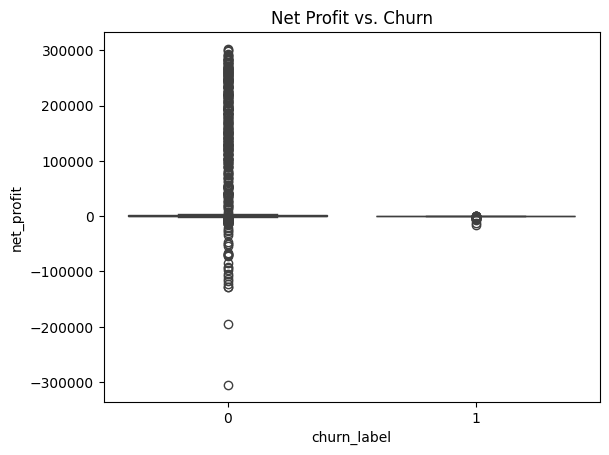

KeyError: 'churn_label'

In [ ]:
invalid_cols = ['total_deposit', 'total_withdrawal', 'net_profit', 'net_ggr','total_bet_amount', 'bonus_per_deposit', 'withdrawal_deposit_ratio']
for col in invalid_cols:
    neg_count = (df_master[col] < 0).sum()
    if neg_count > 0:
        print(f"⚠️ {neg_count} negative values found in {col}")

df["churn_label"]

# Data Type Consistency

Before merging DataFrames, we need to ensure that joining keys (`player_id`) have consistent data types across all tables. We:
1. Convert all `player_id` columns to integer type
2. Verify the types before merging
3. Apply the merges with consistent types

This prevents the "merging on object and float64 columns" error.

## Feature Overview

The integrated dataset now includes:

1. **Session Behavior**
   - Total sessions and average session length
   - Platform usage (mobile ratio, unique platforms)

2. **Financial Metrics**
   - Deposits and withdrawals
   - Betting amounts and win/loss
   - Net profit calculations
   - Bonus utilization

3. **Gaming Patterns**
   - Unique games played
   - Average bet sizes
   - Win rates

4. **Player Profile**
   - Registration info
   - Country and VIP level
   - Acquisition channel

5. **Derived Metrics**
   - Bonus to deposit ratio
   - Withdrawal to deposit ratio
   - Platform preferences

These features can now be used for churn prediction modeling, with the `churn_label` as our target variable.